##Machine Translation Using a Seq2Seq Architecture

---
The goal of this colab is to get you more familiar with the Seq2Seq models and their challenges. For this reason, you will be working on machine translation problem where we would have a sentence as input (in english), and the output is gonna be the translated sentence (in french). So just like what happens with Google Translate.


**Just to give you a heads up:** We won't be having a model performing like Google translate, but at least we will have an idea about how Google Translate works and the challenges that exist with a translation problem.  

## Importing Libraries

We start by importing numpy and pandas and then we can add the rest

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, LSTM, Bidirectional, Embedding, RepeatVector, TimeDistributed
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Upload your data here. Here is the [Drive link](https://drive.google.com/drive/folders/10ncj3w7kI9GPx_rz-WfKEGCv4Dz1EYf6?usp=sharing)

## Getting the data

In [ ]:
#Test Your Knowledge
from google.colab import drive
drive.mount('/content/drive')

# Replace 'path_to_en.csv' and 'path_to_fr.csv' with the actual paths in your Drive
english_sentences = pd.read_csv('/content/drive/MyDrive/en.csv', header=None)
french_sentences = pd.read_csv('/content/drive/MyDrive/fr.csv', header=None)



Mounted at /content/drive


We read the english sentences in a dataframe named "english", and the french sentences in a dataframe named "french"

**How many sentences does each of the files contain?**

In [ ]:
#Test Your Knowledge
print(f"Number of English sentences: {english_sentences.shape[0]}")
print(f"Number of French sentences: {french_sentences.shape[0]}")


Number of English sentences: 137860
Number of French sentences: 137860


Now let us concatenate the 2 dataframes into one dataframe that we call **df** where one column has the english senetnces and the other has the french sentences

In [ ]:
#Test Your Knowledge
df = pd.concat([english_sentences, french_sentences], axis=1)


Let's name the columns as **English** and **French** so that we access them easier.

In [ ]:
#Test Your Knowledge
df.columns = ['English', 'French']


Pick a sentence and print it in both languages

In [ ]:
#Test Your Knowledge
# Display the second sentence pair
print(f"English: {df['English'].iloc[1]}")
print(f"French: {df['French'].iloc[1]}")


English: the united states is usually chilly during july , and it is usually freezing in november .
French: les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


##Cleaning Data

The data that we have is almost clean as we can see, we just need to remove the punctuations inside of it.

In [ ]:
#Test Your Knowledge
import string

# Function to clean sentences
def clean_sentence(sentence):
    sentence = sentence.lower()
    sentence = sentence.strip()
    # Remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    return sentence

# Apply cleaning to both English and French sentences
df['English'] = df['English'].apply(clean_sentence)
df['French'] = df['French'].apply(clean_sentence)


Make sure that the punctuation is removed by printing the example that you printed earlier.

In [ ]:
#Test Your Knowledge
print(f"Cleaned English: {df['English'].iloc[1]}")
print(f"Cleaned French: {df['French'].iloc[1]}")


Cleaned English: the united states is usually chilly during july  and it is usually freezing in november 
Cleaned French: les étatsunis est généralement froid en juillet  et il gèle habituellement en novembre 


##Exploring the Data

Add a column **ENG Length** to the dataset that shows how many words does a sentence contain, and do the same for french in a column called **FR Length**

In [ ]:
df['ENG_Length'] = df['English'].apply(lambda x: len(x.split()))
df['FR_Length'] = df['French'].apply(lambda x: len(x.split()))


Visualize the distribution of the lengths of english sentences and french sentences.

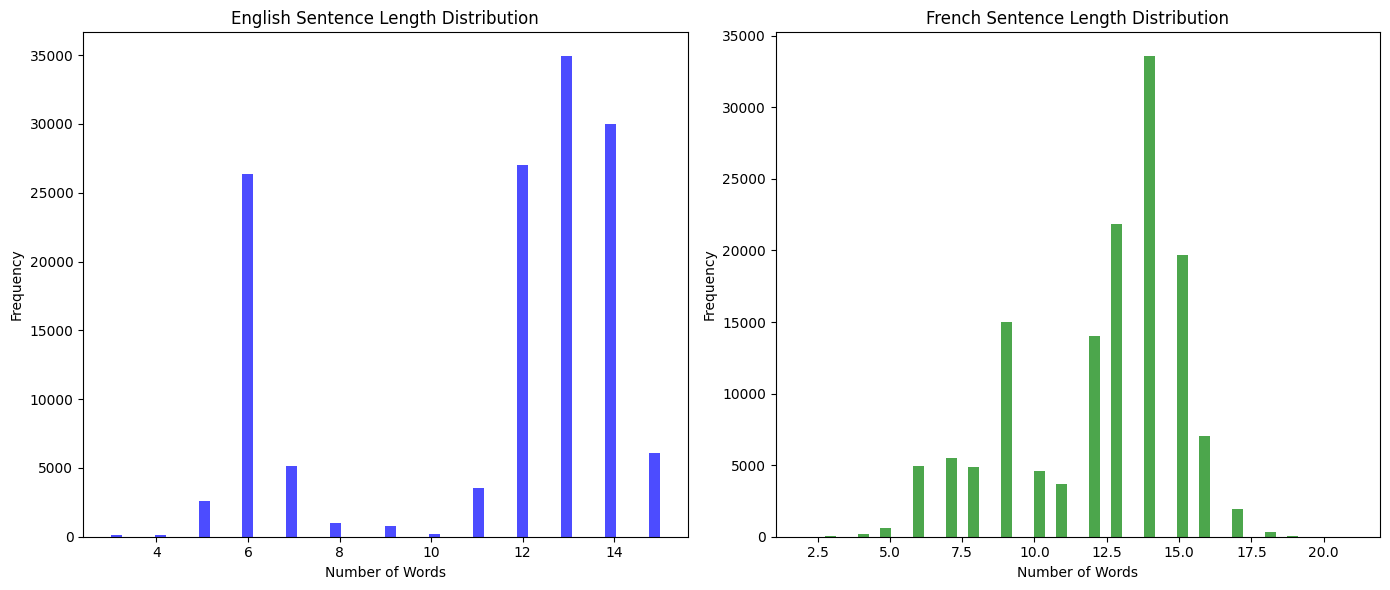

In [ ]:
plt.figure(figsize=(14, 6))

# English Sentence Length Distribution
plt.subplot(1, 2, 1)
plt.hist(df['ENG_Length'], bins=50, color='blue', alpha=0.7)
plt.title('English Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# French Sentence Length Distribution
plt.subplot(1, 2, 2)
plt.hist(df['FR_Length'], bins=50, color='green', alpha=0.7)
plt.title('French Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**Graph shows the distribution of sentence lengths for english and french sentences, blue is english showing english sentences have lengths clustered between 12 and 14 tokens while green french shows sentences have a wider range with a peak around 12 and 15  tokens  suggesting french translations tend to be slightly longer on average.**

In [ ]:
#Test Your Knowledge

Get the maximum length of an english sentence and the maximum length of a french sentence.

In [ ]:
max_eng_length = df['ENG_Length'].max()
max_fr_length = df['FR_Length'].max()

print(f"Maximum English Sentence Length: {max_eng_length}")
print(f"Maximum French Sentence Length: {max_fr_length}")


Maximum English Sentence Length: 15
Maximum French Sentence Length: 21


##Preprocessing the Data

In order for the data to be fed to the model, it has to be tokenized and padded.

####Tokenization

**To tokenize english and french sentences, we can use only one tokenizer. True or False?**

**We can use both one and two tokenizers but the 2 is better in performance as shown in training epochs in both, note that at the end of the collab there  is the one tokenizer  and the first one was 2 so it is TRUE......**



Shared Token Indexing offers several important benefits for multilingual models. It consistently handles common tokens like numbers, punctuation, and proper nouns across different languages using a single tokenizer, which allows shared embeddings and improves understanding. This approach also enables cross-lingual understanding by assigning similar embeddings to words with similar spellings or meanings, making translations smoother. By using one tokenizer, the process of converting sentences to sequences and back becomes unified and less complex during training and inference. Additionally, both the input and output layers share the same vocabulary size, simplifying the model’s architecture. The unified encoder and decoder use the same token representations, allowing the model to effectively map phrases from one language to another, such as translating "good morning" to "bonjour." This method ensures language independence, enabling Seq2Seq models to translate seamlessly as long as the same token set is used. Finally, architectures like transformers take advantage of shared tokenizers to learn relationships within and between languages, accurately mapping meanings like "I am happy" to "Je suis heureux." Overall, Shared Token Indexing enhances the efficiency and accuracy of multilingual models by maintaining a unified and consistent token representation.



Tokenize the sentences that we have.

In [ ]:
# Tokenize English sentences
eng_tokenizer = Tokenizer(oov_token='<OOV>')
eng_tokenizer.fit_on_texts(df['English'])
eng_vocab_size = len(eng_tokenizer.word_index) + 1


# Tokenize French sentences
fr_tokenizer = Tokenizer(oov_token='<OOV>')
fr_tokenizer.fit_on_texts(df['French'])
fr_vocab_size = len(fr_tokenizer.word_index) + 1



**How many unique words do we have in english and in french?**

In [ ]:
print(f'English Vocabulary Size: {eng_vocab_size}')
print(f'French Vocabulary Size: {fr_vocab_size}')


English Vocabulary Size: 201
French Vocabulary Size: 346


####Padding

**What should be the length of the sequences that we have after padding?**

**The sequences should be padded to the maximum sentence length in the dataset to ensure uniform input size for the model.**

Perform padding on the sequences that we have.The sequences should be padded to the maximum sentence length in the dataset to ensure uniform input size for the model.

In [ ]:
# Convert sentences to sequences
eng_sequences = eng_tokenizer.texts_to_sequences(df['English'])
fr_sequences = fr_tokenizer.texts_to_sequences(df['French'])
#The texts_to_sequences method takes sentences from the DataFrame columns (df['English'] and df['French']) and converts them into sequences of integers
#based on the vocabulary learned by the tokenizers
# Find the maximum sentence lengths
max_eng_length = max([len(seq) for seq in eng_sequences])
max_fr_length = max([len(seq) for seq in fr_sequences])
#The code calculates the maximum length of the sequences in both the English and French data. It iterates through each sequence
#to find the one with the most tokens.
print(f'Maximum English Sentence Length: {max_eng_length}')
print(f'Maximum French Sentence Length: {max_fr_length}')

# Pad the sequences
eng_padded = pad_sequences(
    eng_sequences,
    maxlen=max_eng_length,
    padding='post',
    truncating='post'
)
#The pad_sequences function ensures that all sequences are of equal length by adding padding (usually zeros) at the end (padding='post').
#If any sequence is longer than maxlen, it will be truncated from the end (truncating='post').
fr_padded = pad_sequences(
    fr_sequences,
    maxlen=max_fr_length,
    padding='post',
    truncating='post'
)

print(f'Padded English Sequences Shape: {eng_padded.shape}')
print(f'Padded French Sequences Shape: {fr_padded.shape}')


Maximum English Sentence Length: 15
Maximum French Sentence Length: 21
Padded English Sequences Shape: (137860, 15)
Padded French Sequences Shape: (137860, 21)


##Modeling

After preprrocessing the data, we can build our model. Start by building a baseline architecture relying on one directional RNNs, LSTMs, or GRUs. It will be good to lookup how to build Seq2Seq models, there are some new layers that will help you like RepeatVector and TimeDistributed.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    eng_padded,
    fr_padded,
    test_size=0.2,
    random_state=42
)

print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}')


X_train Shape: (110288, 15)
X_test Shape: (27572, 15)
y_train Shape: (110288, 21)
y_test Shape: (27572, 21)


In [ ]:
# Build the Seq2Seq model using Sequential API
model = Sequential()
# Initializes a sequential model where layers are added one after another.
# Encoder
model.add(Embedding(
    input_dim=eng_vocab_size,
    output_dim=256,
    input_length=max_eng_length,
    mask_zero=True
))
#Converts input words (represented as integers from the tokenizer) into dense vector representations.
#This helps the model learn semantic relationships between words.
#This layer helps the model learn relationships between words and their meanings during training by updating the vector representations.
model.add(LSTM(256))
# Processes the input sequence and captures dependencies between words to create a context vector that summarizes the input sentence.
# Repeat the context vector for as many times as the max length of the target sentences
#The LSTM is designed to remember long sequences and manage gradient flow effectively, reducing vanishing gradient issues seen in traditional RNNs.
model.add(RepeatVector(max_fr_length))
#Takes the context vector from the encoder and repeats it max_fr_length times to match the length of the target sequence.
# Ensures that the decoder receives a consistent input at each time step, allowing it to generate an output sequence.

# Decoder
model.add(LSTM(256, return_sequences=True))
#This layer acts as the decoder, processing the repeated context vector and generating an output sequence.
# Unlike the encoder LSTM, this decoder LSTM is set to return_sequences=True, which means it returns a full sequence of outputs (one for each time step)
#to be used for further processing.
# TimeDistributed Dense layer with softmax activation
model.add(TimeDistributed(Dense(fr_vocab_size, activation='softmax')))
#This layer applies a Dense (fully connected) layer to each time step of the decoder's output. It outputs a probability distribution over the French vocabulary
#for each word position.This allows the model to generate a probability distribution over the French vocabulary for each word in the output sequence.
# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Compile and train the model.
**FYI:** While specifying the architecture of your model and the number of epochs for training, keeep in your mind that your model might take A LOT of time to train.

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

print(f'Reshaped y_train Shape: {y_train.shape}')
print(f'Reshaped y_test Shape: {y_test.shape}')


Reshaped y_train Shape: (110288, 21, 1)
Reshaped y_test Shape: (27572, 21, 1)


In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test)
)


Epoch 1/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.5736 - loss: 1.8729 - val_accuracy: 0.7981 - val_loss: 0.6901
Epoch 2/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8255 - loss: 0.5923 - val_accuracy: 0.9009 - val_loss: 0.3292
Epoch 3/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9191 - loss: 0.2801 - val_accuracy: 0.9521 - val_loss: 0.1683
Epoch 4/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9557 - loss: 0.1514 - val_accuracy: 0.9631 - val_loss: 0.1228
Epoch 5/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9650 - loss: 0.1158 - val_accuracy: 0.9692 - val_loss: 0.1010
Epoch 6/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9735 - loss: 0.0861 - val_accuracy: 0.9728 - val_loss: 0.0869
Epoch 7/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9776 - loss: 0.0719 - val_accuracy: 0.9761 - val_loss: 0.0779
Epoch 8/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9786 -

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


862/862 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9807 - loss: 0.0637
Test Loss: 0.0640
Test Accuracy: 0.9806


Define a function that gets an input sentence in english and gives the output sentence in the french language.

In [ ]:
# Function to translate English sentences to French
def translate(sentence):
    # Clean the sentence
    sentence = clean_sentence(sentence)
    # Tokenize the sentence
    sequence = eng_tokenizer.texts_to_sequences([sentence])
    # Pad the sequence
    sequence = pad_sequences(
        sequence,
        maxlen=max_eng_length,
        padding='post',
        truncating='post'
    )
    # Predict the sequence
    prediction = model.predict(sequence)
    # Take the argmax to get the predicted word indices
    prediction = np.argmax(prediction, axis=-1)[0]
    # Convert indices to words
    predicted_sentence = ''
    for idx in prediction:
        if idx != 0:
            word = fr_tokenizer.index_word.get(idx, '')
            predicted_sentence += word + ' '
    return predicted_sentence.strip()


Test the following sentence

In [ ]:
input = "she is driving the truck"
print(f"English: {input}")
print(f"French (Predicted): {translate(input)}")

#Test Your Knowledge

English: she is driving the truck
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
French (Predicted): elle conduit le camion bleu brillant


**i have a high accuracy but it is not 100% correct. either the dataset is too small or this is the translation in the actual dataset.**

In [ ]:
# Function to plot training and validation accuracy and loss
def plot_training_history(history):
    # Plot Training & Validation Accuracy Values
    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


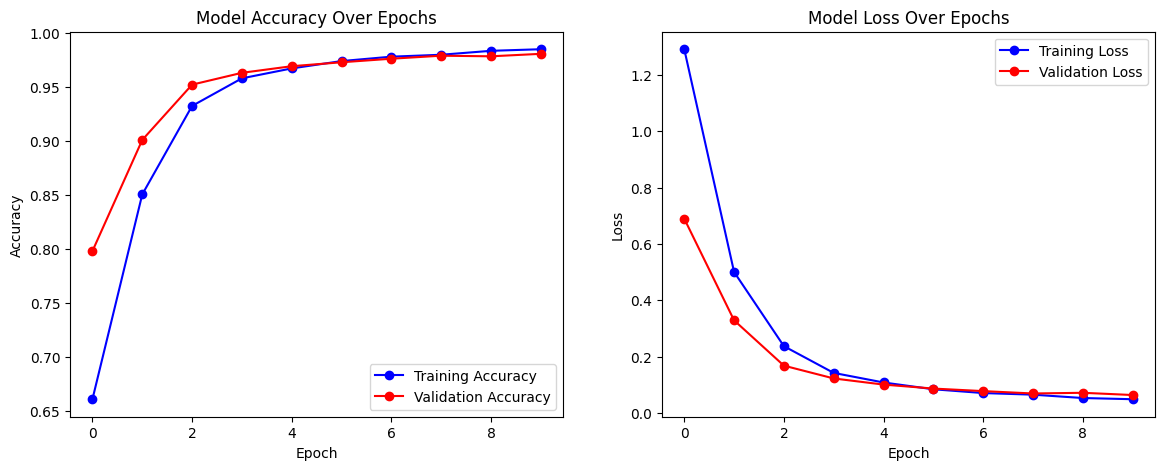

In [ ]:
plot_training_history(history)


Try to improve your model by modifying the architecture to take into account bidirectionality which is very useful in Machine Translation. Create a new model called model2

In [ ]:
from tensorflow.keras.layers import Bidirectional
# Build the Seq2Seq model with Bidirectional LSTM using Sequential API
model2 = Sequential()

# Encoder with Bidirectional LSTM
model2.add(Embedding(
    input_dim=eng_vocab_size,
    output_dim=256,
    input_length=max_eng_length,
    mask_zero=True
))
model2.add(Bidirectional(LSTM(256, return_sequences=False)))

# Repeat the context vector for as many times as the max length of the target sentences
model2.add(RepeatVector(max_fr_length))

# Decoder with LSTM
model2.add(LSTM(256, return_sequences=True))

# TimeDistributed Dense layer with softmax activation
model2.add(TimeDistributed(Dense(fr_vocab_size, activation='softmax')))

# Display the model summary
model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

compile and train your new model.

In [ ]:
# Compile the new model
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



# Train the new model and capture the training history
history2 = model2.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test)
)


Epoch 1/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.6013 - loss: 1.7415 - val_accuracy: 0.8299 - val_loss: 0.5614
Epoch 2/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.8649 - loss: 0.4503 - val_accuracy: 0.9403 - val_loss: 0.2171
Epoch 3/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.9460 - loss: 0.1914 - val_accuracy: 0.9601 - val_loss: 0.1307
Epoch 4/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.9614 - loss: 0.1262 - val_accuracy: 0.9696 - val_loss: 0.0992
Epoch 5/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.9721 - loss: 0.0909 - val_accuracy: 0.9703 - val_loss: 0.0952
Epoch 6/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.9758 - loss: 0.0772 - val_accuracy: 0.9742 - val_loss: 0.0832
Epoch 7/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.9806 - loss: 0.0626 - val_accuracy: 0.9763 - val_loss: 0.0756
Epoch 8/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.9826 -

**less than  0.5% better. but it would not be very logical to  use bidirectional because they are both read from the same direction aka left to right unlike english and arabic as explained in class that do need bidirectional**

Define a new function that relies on your new model to make predictions.

In [ ]:
# Function to translate English sentences to French using model2
def translate_model2(sentence):
    # Clean the sentence
    sentence = clean_sentence(sentence)
    # Tokenize the sentence
    sequence = eng_tokenizer.texts_to_sequences([sentence])
    # Pad the sequence
    sequence = pad_sequences(
        sequence,
        maxlen=max_eng_length,
        padding='post',
        truncating='post'
    )
    # Predict the sequence
    prediction = model2.predict(sequence)
    # Take the argmax to get the predicted word indices
    prediction = np.argmax(prediction, axis=-1)[0]
    # Convert indices to words
    predicted_sentence = ''
    for idx in prediction:
        if idx != 0:
            word = fr_tokenizer.index_word.get(idx, '')
            predicted_sentence += word + ' '
    return predicted_sentence.strip()


In [ ]:
input = "she is driving the truck"
print(f"English: {input}")
print(f"French (Predicted by model2): {translate_model2(input)}")


English: she is driving the truck
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
French (Predicted by model2): elle conduit le camion camion brillant



[One Tokenizer] Vocabulary Size: 529
[One Tokenizer] Maximum Sentence Length: 21

[One Tokenizer] Padded English Sequences Shape: (137860, 21)
[One Tokenizer] Padded French Sequences Shape: (137860, 21)

[One Tokenizer] X_train Shape: (110288, 21)
[One Tokenizer] X_test Shape: (27572, 21)
[One Tokenizer] y_train Shape: (110288, 21)
[One Tokenizer] y_test Shape: (27572, 21)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_3 (RepeatVector)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


[One Tokenizer] Reshaped y_train Shape: (110288, 21, 1)
[One Tokenizer] Reshaped y_test Shape: (27572, 21, 1)
Epoch 1/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.5623 - loss: 1.9629 - val_accuracy: 0.7709 - val_loss: 0.7724
Epoch 2/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8032 - loss: 0.6614 - val_accuracy: 0.8824 - val_loss: 0.3913
Epoch 3/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9076 - loss: 0.3173 - val_accuracy: 0.9483 - val_loss: 0.1823
Epoch 4/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9534 - loss: 0.1625 - val_accuracy: 0.9646 - val_loss: 0.1192
Epoch 5/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9657 - loss: 0.1152 - val_accuracy: 0.9715 - val_loss: 0.0930
Epoch 6/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9730 - loss: 0.0892 - val_accuracy: 0.9738 - val_loss: 0.0873
Epoch 7/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9773 - loss: 0.0734 - val_a

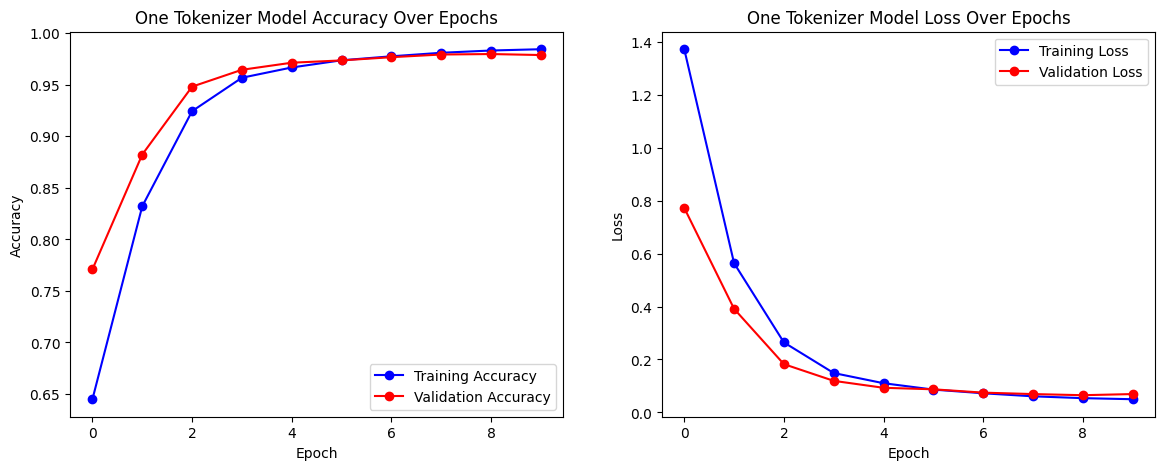

In [ ]:
# ----------------------------- #
#     One Tokenizer Approach     #
# ----------------------------- #

# Combine all sentences (both English and French) into one list for a single tokenizer
all_sentences_one_tokenizer = df['English'].tolist() + df['French'].tolist()

# Create and fit the single tokenizer with an Out-Of-Vocabulary (OOV) token
tokenizer_one = Tokenizer(oov_token='<OOV>')
tokenizer_one.fit_on_texts(all_sentences_one_tokenizer)

# Vocabulary size (including OOV token)
vocab_size_one = len(tokenizer_one.word_index) + 1
print(f'\n[One Tokenizer] Vocabulary Size: {vocab_size_one}')

# ----------------------------- #
#      Step 2: Tokenize and Pad the Sentences
# ----------------------------- #

# Convert English and French sentences to sequences using the single tokenizer
eng_sequences_one = tokenizer_one.texts_to_sequences(df['English'])
fr_sequences_one = tokenizer_one.texts_to_sequences(df['French'])

# Find the maximum sentence length (ensure it's consistent with Two Tokenizer approach if needed)
max_length_one = max(df['ENG_Length'].max(), df['FR_Length'].max())
print(f"[One Tokenizer] Maximum Sentence Length: {max_length_one}")

# Pad the sequences to ensure uniform length
eng_padded_one = pad_sequences(
    eng_sequences_one,
    maxlen=max_length_one,
    padding='post',
    truncating='post'
)

fr_padded_one = pad_sequences(
    fr_sequences_one,
    maxlen=max_length_one,
    padding='post',
    truncating='post'
)

print(f'\n[One Tokenizer] Padded English Sequences Shape: {eng_padded_one.shape}')
print(f'[One Tokenizer] Padded French Sequences Shape: {fr_padded_one.shape}')

# ----------------------------- #
#      Step 3: Split the Data into Training and Testing Sets
# ----------------------------- #

X_train_one, X_test_one, y_train_one, y_test_one = train_test_split(
    eng_padded_one,
    fr_padded_one,
    test_size=0.2,
    random_state=42
)

print(f'\n[One Tokenizer] X_train Shape: {X_train_one.shape}')
print(f'[One Tokenizer] X_test Shape: {X_test_one.shape}')
print(f'[One Tokenizer] y_train Shape: {y_train_one.shape}')
print(f'[One Tokenizer] y_test Shape: {y_test_one.shape}')

# ----------------------------- #
#      Step 4: Build the Seq2Seq Model with One Tokenizer
# ----------------------------- #

# Build the Seq2Seq model using Sequential API for one tokenizer
model_one_tokenizer = Sequential()

# Encoder
model_one_tokenizer.add(Embedding(
    input_dim=vocab_size_one,
    output_dim=256,
    input_length=max_length_one,
    mask_zero=True
))
model_one_tokenizer.add(LSTM(256))

# Repeat the context vector for as many times as the max length of the target sentences
model_one_tokenizer.add(RepeatVector(max_length_one))

# Decoder
model_one_tokenizer.add(LSTM(256, return_sequences=True))

# TimeDistributed Dense layer with softmax activation
model_one_tokenizer.add(TimeDistributed(Dense(vocab_size_one, activation='softmax')))

# Display the model summary
model_one_tokenizer.summary()

# ----------------------------- #
#      Step 5: Compile the Model
# ----------------------------- #

model_one_tokenizer.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ----------------------------- #
#      Step 6: Prepare the Target Data
# ----------------------------- #

# Reshape the target data to 3D (samples, timesteps, 1) as required by the loss function
y_train_one = y_train_one.reshape(y_train_one.shape[0], y_train_one.shape[1], 1)
y_test_one = y_test_one.reshape(y_test_one.shape[0], y_test_one.shape[1], 1)

print(f'\n[One Tokenizer] Reshaped y_train Shape: {y_train_one.shape}')
print(f'[One Tokenizer] Reshaped y_test Shape: {y_test_one.shape}')

# ----------------------------- #
#      Step 7: Train the Model
# ----------------------------- #


# Train the one tokenizer model and capture the training history
history_one = model_one_tokenizer.fit(
    X_train_one,
    y_train_one,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_one, y_test_one),

)

# ----------------------------- #
#      Step 8: Evaluate the Model
# ----------------------------- #

loss_one, accuracy_one = model_one_tokenizer.evaluate(X_test_one, y_test_one)
print(f'\n[One Tokenizer] Test Loss: {loss_one:.4f}')
print(f'[One Tokenizer] Test Accuracy: {accuracy_one:.4f}')

# ----------------------------- #
#      Step 9: Make Predictions
# ----------------------------- #

# Function to translate English sentences to French using the one tokenizer model
def translate_one_tokenizer(sentence):
    # Clean the sentence
    sentence = clean_sentence(sentence)
    # Tokenize the sentence using the single tokenizer
    sequence = tokenizer_one.texts_to_sequences([sentence])
    # Pad the sequence
    sequence = pad_sequences(
        sequence,
        maxlen=max_length_one,
        padding='post',
        truncating='post'
    )
    # Predict the sequence
    prediction = model_one_tokenizer.predict(sequence)
    # Take the argmax to get the predicted word indices
    prediction = np.argmax(prediction, axis=-1)[0]
    # Convert indices to words using the single tokenizer's index_word
    predicted_sentence = ''
    for idx in prediction:
        if idx != 0:
            word = tokenizer_one.index_word.get(idx, '')
            predicted_sentence += word + ' '
    return predicted_sentence.strip()

# Example translation using the one tokenizer model
print("\n[One Tokenizer] Example Translation:")
english_sentence = "she is driving the truck"
print(f"English: {english_sentence}")
print(f"French (Predicted by one tokenizer): {translate_one_tokenizer(english_sentence)}")

# ----------------------------- #
#      Step 10: Visualize Training History
# ----------------------------- #

# Function to plot training and validation accuracy and loss
def plot_training_history_one(history):
    # Plot Training & Validation Accuracy Values
    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('One Tokenizer Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('One Tokenizer Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history for the one tokenizer model
plot_training_history_one(history_one)


**What is another adjustment in terms of architecture that you might be able to do to improve your model?**


### **Multi-Head Attention Mechanism**

Multi-head attention is a key feature of transformer models that allows the model to focus on different parts of the input sentence simultaneously when generating each word in the output. For example, in the sentence "The cat sat on the mat," one attention head might focus on "The cat," another on "sat," and another on "on the mat." Each head processes the input independently, capturing multiple relationships at once. This enhances the model’s ability to understand complex dependencies within the sequence. In our translation project, multi-head attention helps align relevant parts of the English sentence with their French counterparts, such as matching "cat" with "chat" and "sat" with "s'est assis." By adding multi-head attention to our Seq2Seq architecture, we achieve more accurate and contextually appropriate translations, improving overall translation quality.



**What are some additional ways that we can do to improve the performance of our model?**


### **Explore Hybrid Architectures (LSTM + Convolutional Layers)**

Hybrid architectures combine convolutional layers with LSTM layers to enhance machine translation. Convolutional layers excel at capturing local patterns, such as short phrases, acting as preprocessors that detect important word groups like "sat on." These features are then passed to LSTM layers, which understand sequential data and long-term dependencies, analyzing the broader sentence structure and context. This combination leverages both local and global information, ensuring that models receive informative inputs and maintain coherent sequence flow. For example, in English-to-French translation, convolutional layers might extract phrases like "The cat" or "on the mat," while LSTM layers ensure these patterns contribute to producing accurate and contextually appropriate translations like “Le chat est assis sur le tapis.” This dual processing improves overall translation quality by integrating detailed pattern recognition with comprehensive sequence understanding.



###**Apply Layer Normalization**

Layer normalization stabilizes neural network training by normalizing each layer’s output to have a mean of 0 and a variance of 1. Unlike input normalization, which standardizes the input data, layer normalization is applied to the outputs of layers like LSTM or dense layers. This prevents issues like vanishing and exploding gradients, ensuring that activations remain stable and well-scaled as data moves through the network. As a result, models train more efficiently and converge faster, allowing deeper architectures to learn without instability. In my current implementation, input preprocessing steps such as tokenization and padding ensure consistent input data. In contrast, layer normalization operates within the model itself, normalizing outputs after each layer to maintain a consistent scale and enhance overall training stability.


###**Tokenizer Adaptations for Different Language Pairs**

When adapting tokenizers for different language pairs, several adjustments are necessary to handle each language's unique characteristics.

For **English to Latin translation**, the tokenizer combines vocabularies from both languages, manages different punctuation and diacritics like "ā," and uses strategies like <OOV> tokens for unknown words.

For **English to English tasks** such as paraphrasing or summarization, the tokenizer maintains a consistent English vocabulary and employs subword techniques like BPE or WordPiece to handle rare or new words.

In **English to Arabic translation**, the tokenizer must handle different scripts, manage right-to-left text direction, and break down complex Arabic word forms into roots and affixes. It also uses subword tokenization to manage rich morphology and decides whether to keep or discard diacritics based on the application. Additionally, the tokenizer combines English and Arabic vocabularies into a larger, versatile set and segments Arabic words into meaningful parts, unlike the space-based splitting used in English. Overall, the tokenizer adapts by expanding vocabulary sizes, effectively handling morphological differences, utilizing subword units, and respecting each language’s grammatical nuances to ensure accurate and efficient translation.
